## 作業

1. 請自行定義一個 loss function = 0.3 * focal-loss + 0.7 cross-entropy，並訓練比較結果。

## 參考資料

[Focal Loss Function](https://blog.csdn.net/u014380165/article/details/77019084)

[Keras 自定义 Loss Function](https://blog.csdn.net/A_a_ron/article/details/79050204)

[TensorFlow 101：常數、變數與 Placeholder](https://medium.com/datainpoint/tf101-constants-variables-and-placeholders-d36cf13d9e21)

In [1]:
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import SGD
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
def make_custom_loss(alpha=2.0, beta=1.0, gamma=2.0, epsilon=1e-8):

    def custom_loss(y_true, y_pred):
        yt = tf.convert_to_tensor(y_true, tf.float32)
        pt = tf.add(tf.convert_to_tensor(y_pred, tf.float32), epsilon)
        ce = tf.multiply(yt, -tf.log(pt))
        fl = tf.multiply(alpha, tf.multiply(tf.pow(tf.subtract(1., pt), gamma), ce))
        cl = tf.add(tf.multiply(tf.subtract(1., beta), ce), tf.multiply(beta, fl))
        return tf.reduce_mean(tf.reduce_max(cl, axis=1))

    return custom_loss

class Trainer:

    def __init__(self, X_train, y_train, X_test, y_test, build_param, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=1024, momentum=0.95, learning_rate=1e-3):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.neuron_numbers = neuron_numbers
        self.build_param = build_param
        self._model = None
        self._history = None

    @property
    def loss(self):
        alpha = self.build_param.custom_loss_alpha
        beta = self.build_param.custom_loss_beta
        gamma = self.build_param.custom_loss_gamma
        return make_custom_loss(alpha=alpha, beta=beta, gamma=gamma)

    @property
    def optimizer(self):
        return SGD(lr=self.learning_rate, momentum=self.momentum, nesterov=True)

    @property
    def validation_data(self):
        return (self.X_test, self.y_test,)

    def run(self):
        return self._clear()._build()._launch()

    def _clear(self):
        backend.clear_session()
        self._model = None
        return self

    def _build(self):
        main_input = hidden_input = Input(shape=self.X_train.shape[-1:], name='main_input')
        for i, neuron_number in enumerate(self.neuron_numbers):
            hidden_input = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}')(hidden_input)
            hidden_input = BatchNormalization()(hidden_input)
        main_output = Dense(units=self.y_train.shape[-1], activation='softmax', name='main_output')(hidden_input)
        self._model = Model(inputs=[main_input], outputs=[main_output])
        self._model.compile(optimizer=self.optimizer, loss=self.loss, metrics=['accuracy'])
        return self

    def _launch(self):
        print('Experiment with label: {}'.format(self.build_param.label))
        self._model.summary()
        self._history = self._model.fit(
            self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size,
            validation_data=self.validation_data, shuffle=True, verbose=2)
        return self

    def display(self, train_name, val_name, color):
        plt.plot(self._history.history[train_name], '-', label='exp: {}'.format(self.build_param.label), color=color)
        plt.plot(self._history.history[val_name], '--', label='exp: {}'.format(self.build_param.label), color=color)

class BuildParam:

    def __init__(self, custom_loss_alpha, custom_loss_beta, custom_loss_gamma):
        self.custom_loss_alpha = custom_loss_alpha
        self.custom_loss_beta = custom_loss_beta
        self.custom_loss_gamma = custom_loss_gamma

    @property
    def label(self):
        return 'α={:.2f}, β={:.2f}, γ={:.2f}'.format(self.custom_loss_alpha, self.custom_loss_beta, self.custom_loss_gamma)

class BatchTrainer:
    
    def __init__(self, trainers):
        self.trainers = trainers
        self.total_amount = len(trainers)

    @property
    def colors(self):
        color_map = cm.ScalarMappable(cmap=plt.get_cmap('gist_rainbow'),
                                      norm=colors.Normalize(vmin=0, vmax=self.total_amount - 1))
        return [color_map.to_rgba(i) for i in range(self.total_amount)]

    def run(self):
        for i in range(self.total_amount):
            self.trainers[i].run()
        return self

    def display(self, train_name, val_name):
        plt.figure(figsize=(12, 7,))
        for i, color in enumerate(self.colors):
            self.trainers[i].display(train_name, val_name, color)
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5,))
        plt.show()

## 以自訂函數不同的 beta 值觀看學習曲線的走勢

In [7]:
# 設定超參數
alphas = (2.0,)
betas = (0.0, 0.3, 0.5, 0.7, 1.0,)
gammas = (2.0,)

params = [BuildParam(*args) for args in itertools.product(alphas, betas, gammas)]
trainers = [Trainer(X_train, y_train, X_test, y_test, param) for param in params]

In [8]:
batch_trainer = BatchTrainer(trainers).run()

Experiment with label: α=2.00, β=0.00, γ=2.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (

 - 9s - loss: 1.2903 - acc: 0.5894 - val_loss: 1.6469 - val_acc: 0.4774
Epoch 14/50
 - 9s - loss: 1.2585 - acc: 0.6000 - val_loss: 1.6364 - val_acc: 0.4813
Epoch 15/50
 - 9s - loss: 1.2260 - acc: 0.6103 - val_loss: 1.6279 - val_acc: 0.4821
Epoch 16/50
 - 9s - loss: 1.1943 - acc: 0.6210 - val_loss: 1.6374 - val_acc: 0.4838
Epoch 17/50
 - 9s - loss: 1.1649 - acc: 0.6301 - val_loss: 1.6278 - val_acc: 0.4855
Epoch 18/50
 - 9s - loss: 1.1370 - acc: 0.6389 - val_loss: 1.6260 - val_acc: 0.4904
Epoch 19/50
 - 8s - loss: 1.1082 - acc: 0.6478 - val_loss: 1.6146 - val_acc: 0.4927
Epoch 20/50
 - 8s - loss: 1.0785 - acc: 0.6573 - val_loss: 1.6390 - val_acc: 0.4838
Epoch 21/50
 - 9s - loss: 1.0523 - acc: 0.6640 - val_loss: 1.6217 - val_acc: 0.4885
Epoch 22/50
 - 8s - loss: 1.0251 - acc: 0.6735 - val_loss: 1.6355 - val_acc: 0.4836
Epoch 23/50
 - 9s - loss: 1.0019 - acc: 0.6820 - val_loss: 1.6336 - val_acc: 0.4889
Epoch 24/50
 - 9s - loss: 0.9748 - acc: 0.6930 - val_loss: 1.6318 - val_acc: 0.4936
Epoc

Epoch 43/50
 - 8s - loss: 0.4719 - acc: 0.8660 - val_loss: 2.0340 - val_acc: 0.4926
Epoch 44/50
 - 9s - loss: 0.4545 - acc: 0.8718 - val_loss: 2.0613 - val_acc: 0.4898
Epoch 45/50
 - 9s - loss: 0.4372 - acc: 0.8777 - val_loss: 2.0891 - val_acc: 0.4845
Epoch 46/50
 - 9s - loss: 0.4156 - acc: 0.8876 - val_loss: 2.1346 - val_acc: 0.4838
Epoch 47/50
 - 9s - loss: 0.3979 - acc: 0.8912 - val_loss: 2.1224 - val_acc: 0.4866
Epoch 48/50
 - 9s - loss: 0.3787 - acc: 0.8999 - val_loss: 2.1493 - val_acc: 0.4874
Epoch 49/50
 - 8s - loss: 0.3613 - acc: 0.9064 - val_loss: 2.1985 - val_acc: 0.4861
Epoch 50/50
 - 9s - loss: 0.3461 - acc: 0.9128 - val_loss: 2.1795 - val_acc: 0.4884
Experiment with label: α=2.00, β=0.70, γ=2.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Den

 - 9s - loss: 1.8901 - acc: 0.5064 - val_loss: 2.1326 - val_acc: 0.4526
Epoch 6/50
 - 9s - loss: 1.8019 - acc: 0.5214 - val_loss: 2.0864 - val_acc: 0.4603
Epoch 7/50
 - 9s - loss: 1.7319 - acc: 0.5383 - val_loss: 2.0716 - val_acc: 0.4620
Epoch 8/50
 - 9s - loss: 1.6609 - acc: 0.5513 - val_loss: 1.9988 - val_acc: 0.4778
Epoch 9/50
 - 9s - loss: 1.5948 - acc: 0.5654 - val_loss: 1.9966 - val_acc: 0.4797
Epoch 10/50
 - 9s - loss: 1.5360 - acc: 0.5779 - val_loss: 2.0122 - val_acc: 0.4702
Epoch 11/50
 - 9s - loss: 1.4774 - acc: 0.5905 - val_loss: 1.9823 - val_acc: 0.4837
Epoch 12/50
 - 9s - loss: 1.4273 - acc: 0.6019 - val_loss: 2.0040 - val_acc: 0.4788
Epoch 13/50
 - 9s - loss: 1.3784 - acc: 0.6106 - val_loss: 1.9903 - val_acc: 0.4879
Epoch 14/50
 - 9s - loss: 1.3241 - acc: 0.6242 - val_loss: 1.9511 - val_acc: 0.4885
Epoch 15/50
 - 9s - loss: 1.2756 - acc: 0.6351 - val_loss: 1.9621 - val_acc: 0.4877
Epoch 16/50
 - 9s - loss: 1.2273 - acc: 0.6469 - val_loss: 1.9513 - val_acc: 0.4921
Epoch 17

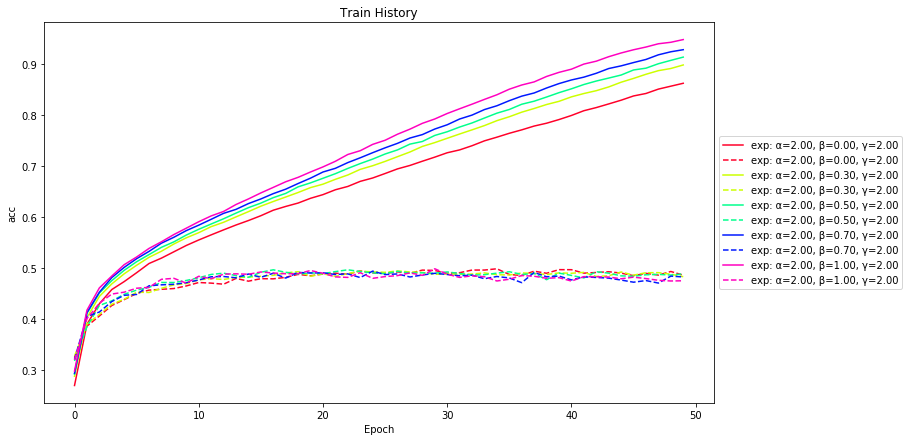

In [9]:
batch_trainer.display('acc', 'val_acc')

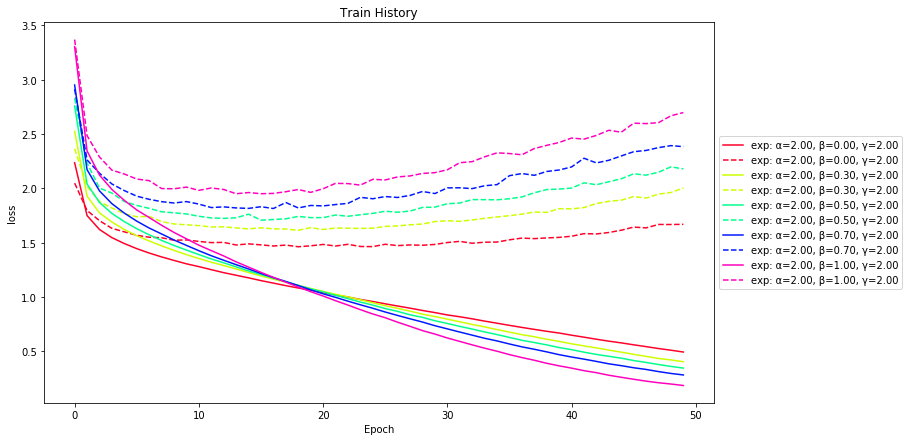

In [10]:
batch_trainer.display('loss', 'val_loss')